In [51]:
%load_ext autoreload
import sys
import os
import numpy as np
import sets
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

SPARTAN_SOURCE_DIR = os.getenv('SPARTAN_SOURCE_DIR')
sys.path.append(os.path.join(SPARTAN_SOURCE_DIR, 'src/ContactParticleFilter/python'))

import lcm
import experimentanalyzer
import tinydb
from tinydb import Query

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
# logFolderName="20180105-165005_simulation"
logFolderName="20180111-000832_simulation"
ea = experimentanalyzer.ExperimentAnalyzer(logFolderName=logFolderName)
ea.run()

num_forces =  3
num_poses =  2
(3, 2)


position
force


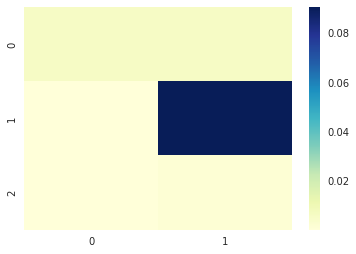

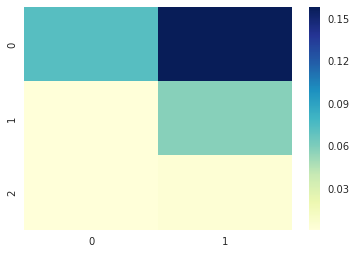

In [90]:
pose_names = sets.Set()
force_names = sets.Set()
for entry in ea.db_analysis.all():
    pose_names.add(entry['pose_name'])
    force_names.add(entry['force_name'])

    
pose_names = list(pose_names)
force_names = list(force_names)

color = ['r','g','b']

"""
Make heatmap of average position error.
x-axis: contact location
y-axis: robot pose

should be three tables, one for each noise level 
"""
def contact_location_accuracy_heatmap(pose_names, force_names, db_analysis, noise_level=None):
    num_poses = len(pose_names)
    num_forces = len(force_names)
    bar_width = 0.7/num_poses
    
    vals = np.zeros([num_forces, num_poses])
    std_dev = np.zeros([num_forces, num_poses])
    
    force_val = np.zeros([num_forces, num_poses])
    force_std_dev = np.zeros([num_forces, num_poses])
    
    print "num_forces = ", num_forces
    print "num_poses = ", num_poses
    print np.shape(vals)
    
    
    for j, pose_name in enumerate(pose_names):
        for i, force_name in enumerate(force_names):
            q = tinydb.Query()
            res = ea.db_analysis.search( (q.pose_name == pose_name) & (q.force_name == force_name))[0]
            vals[i,j] = res['stats']['position']['mean']
            std_dev[i,j] = res['stats']['position']['std_dev']
            
            force_val[i,j] = res['stats']['force']['mean']
            force_std_dev[i,j] = res['stats']['force']['std_dev']

            
    print "\n"
    print "position"
    plt.figure()
    ax_position = sns.heatmap(vals, cmap="YlGnBu")
    
    
    print "force"
    plt.figure()
    ax_force = sns.heatmap(force_val, cmap="YlGnBu")
#     return ax

    
"""
Heatmap
"""

# def contact_location_accuracy_vs_contact_location(pose_names, force_names, db_analysis, noise_level=None):
    

contact_location_accuracy_heatmap(pose_names, force_names, ea.db_analysis)

# Simulation Only Figures
We should make several heatmaps showing the results for simulation from the kuka
- Contact location accuracy for each (force_location, robot_pose) pair
- Contact Force Accuracy for each (force_location, robot_pose) pair

In [48]:
q = Query()
e = ea.db_analysis.search((q.pose_name == "q_nom_down") & (q.force_name == 'iiwa_link_6_1'))[0]
print e['lcm_log_file']

20180105-165102.lcm


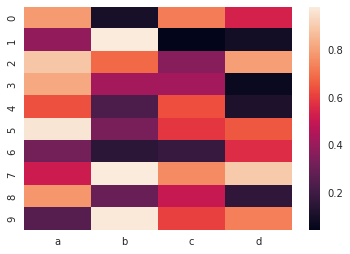

In [55]:
uniform_data = np.random.rand(10, 4)
labels = ['a','b','c','d']

ax = sns.heatmap(uniform_data, xticklabels=labels)

In [91]:
a = [1,2,3]
b = a.pop(0)
print b
print a

1
[2, 3]


In [92]:
a = (1,2,3)
a[0]

1